In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download("popular")
from nltk.corpus import stopwords
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
!pip install nlp-id
!pip install transformers
from keras.preprocessing import sequence
import numpy as np
!pip install torch
!pip install tensorflow
import pandas as pd
import numpy as np
from keras.layers import LSTM, Activation, Dropout, Dense, Input
from tensorflow import keras
from tensorflow.keras import layers as L
from keras.models import Model
import string
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.5/320.5 kB 36.4 MB/s eta 0:00:00
  Created wheel for nlp-id: filename=nlp_id-0.1.15.0-py3-none-any.whl size=58153892 sha256=5d507561f960aa43b327cf557971da3fa134cc44e16f1a406187e001e95d27ca
  Stored in directory: /root/.cache/pip/wheels/85/34/2a/deaf7b7896a1eed336b874e1a7732588d40bb7bdc0a824e73e
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=bf072982490842815cb195c88dc6bcfeab8c53a35c1a118a895476d257c29994
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built nlp-id wget
  Attempting uninstall: pytest
    Found existing installation: pytest 7.4.4
    Uninstalling pytest-7.4.4:
      Successfully u

## Load Data

In [ ]:
from io import BytesIO

import requests
import pandas as pd
r = requests.get('https://docs.google.com/spreadsheet/ccc?key=1i3BBozbnx9HSTkMsfMHChvzYwG_2MiFB06U05gitD8U&output=xlsx')
data = r.content
dataset = pd.read_excel(data, 'Prepocessed (3)')
dataset.head()
dataset.shape

(2502, 15)

## Mencari num_words terbaik

In [ ]:
from collections import Counter

# Gabungkan semua teks menjadi satu string besar
all_text = ' '.join(dataset['content_lemma'])

# Hitung frekuensi kata
word_freq = Counter(all_text.split())

# Urutkan kata berdasarkan frekuensi (dari yang paling sering hingga yang paling jarang)
word_freq_sorted = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)

# Lihat 10 kata teratas untuk mendapatkan ide
print(word_freq_sorted[:10])

[('yang', 5150), ('dan', 4368), ('di', 3616), ('dengan', 2743), ('untuk', 2479), ('ini', 1984), ('dari', 1613), ('dalam', 1393), ('itu', 1261), ('juga', 1252)]


## Menentukan max_len terbaik
dengan Percentile

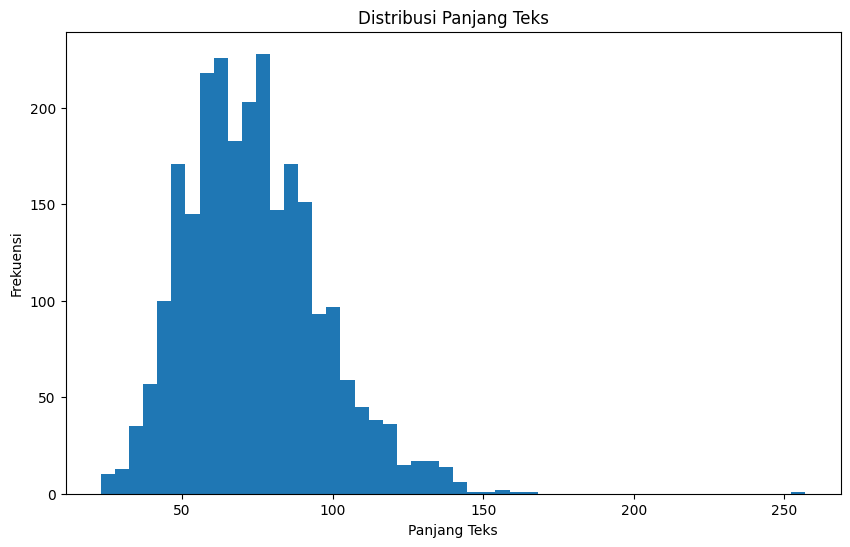

In [ ]:
import matplotlib.pyplot as plt

# Hitung panjang teks untuk setiap dokumen
text_lengths = dataset['content_lemma'].apply(lambda x: len(x.split()))

# Visualisasikan distribusi panjang teks
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=50)
plt.title('Distribusi Panjang Teks')
plt.xlabel('Panjang Teks')
plt.ylabel('Frekuensi')
plt.show()

In [ ]:
max(text_lengths)

257

In [ ]:
# Menemukan nilai max_len berdasarkan persentil
max_len = np.percentile(text_lengths, 80)
max_len

91.80000000000018

## Split Data

In [ ]:
# Misalkan menggunakan `content_lemma` sebagai input
texts = dataset['content_lemma'].values
# Variabel target y adalah kombinasi dari empat label
y = dataset['labels'].values

In [ ]:
from sklearn.model_selection import KFold
#KFold(n_splits=’warn’, shuffle=False, random_state=None)
kf = KFold(5, shuffle=True, random_state=0) # Use for KFold classification

for train_index, validation_index in kf.split(texts):
  #  print("TRAIN:", texts[train_index], "VALIDATION:", texts[validation_index])
   X_train, X_test = texts[train_index], texts[validation_index]
   y_train, y_test = y[train_index], y[validation_index]

In [ ]:
#Y = dataset['labels']
#X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(2002,) (2002,)
(500,) (500,)


In [ ]:
import tensorflow as tf

y_train = tf.keras.utils.to_categorical(y_train, 2)
y_test = tf.keras.utils.to_categorical(y_test, 2)

# GloVe

In [ ]:
!pip install gdown
!gdown 1jgnvIEp8rE3dh68lZXBHfyxzmeky9z6w
# !wget https://drive.google.com/file/d/1jgnvIEp8rE3dh68lZXBHfyxzmeky9z6w/view

Downloading...
From (original): https://drive.google.com/uc?id=1jgnvIEp8rE3dh68lZXBHfyxzmeky9z6w
From (redirected): https://drive.google.com/uc?id=1jgnvIEp8rE3dh68lZXBHfyxzmeky9z6w&confirm=t&uuid=24012f5e-8ee1-4f2b-9758-0b541d443314
To: /content/glove_50dim_wiki.id.case.text.txt
100% 179M/179M [00:02<00:00, 76.0MB/s]


In [ ]:
import codecs
embeddings_index = {}
# for Glove
f = codecs.open('/content/glove_50dim_wiki.id.case.text.txt', encoding='utf-8')
for line in f:
    values = line.rstrip().rsplit(" ")
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

In [ ]:
# Tokenizer
max_features = 10000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X_train)  # Hanya fit ke X_train untuk mencegah data leakage


In [ ]:
vocab_size = len(tokenizer.index_word)+1
vocab_size

10288

In [ ]:
# Convert text to sequence of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Padding
max_length = 257  # asumsi maksimal panjang sequence
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

In [ ]:
print(X_train_pad.shape)
print(X_test_pad.shape)

(2002, 257)
(500, 257)


In [ ]:
# Prepare embedding matrix
embed_dim = 50  # dimensi GloVe vectors yang digunakan
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embed_dim))

# Assign GloVe vectors
words_not_found = []
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

print('Number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

Number of null word embeddings: 2892


In [ ]:
print(words_not_found)

['g', 'tjahjo', 'oppo', 'esports', 'a', 'b', 'huawei', 'expertbook', 's', 'v', 'langgan', 'biznet', 'asus', 'x', 'kumolo', 'xpander', 'd', 'hyundai', 'covid', 'mitsubishi', 'putin', 'messi', 'selenggara', 'c', 'ffml', 'i', 'e', 'zte', 'redmi', 'evos', 'm', 'reno', 'ffim', 'pdip', 'zelensky', 'w', 'epson', 'booyah', 'matebook', 'smartwatch', 'cvt', 'u', 'kalahari', 'lansir', 'purgatory', 'xiaomi', 'wuling', 't', 'enco', 'pmk', 'kyiv', 'perhati', 'mmksi', 'ganjar', 'libat', 'acer', 'garena', 'suv', 'ktt', 'ghz', 'k', 'menpan', 'iims', 'creta', 'pasuk', 'waluyo', 'snapdragon', 'p', 'shopee', 'onic', 'expertcenter', 'z', 'traveloka', 'pdi', 'imos', 'anies', 'mpv', 'megawati', 'neymar', 'lantar', 'axiata', 'barcelona', 'fuso', 'ronaldo', 'mypertamina', 'vladimir', 'biden', 'kingz', 'whatsapp', 'h', 'f', 'ffws', 'gufron', 'menpanrb', 'moskwa', 'gopchang', 'coloros', 'raiders', 'menpora', 'prabowo', 'mahfud', 'kpk', 'irpin', 'yudo', 'fhd', 'bropack', 'xtra', 'rrq', 'hoegeng', 'airlangga', 'ha

In [ ]:
# import tensorflow as tf
# y_train = tf.keras.utils.to_categorical(y_train, 2)
# y_test = tf.keras.utils.to_categorical(y_test, 2)

#tidaklah tepat karena fungsi ini mengubah label menjadi format one-hot encoding yang lebih cocok untuk klasifikasi multi-kelas di mana setiap sampel hanya termasuk dalam satu kelas.

## Saved Embedding Model

In [ ]:
# Step 1: Menyimpan embedding matrix
filename_npy = '/content/drive/MyDrive/Colab Notebooks/Thesis Persuasive Detection at Paragraph-Level  /Embedding Models/glove_embedding.npy'
# Simpan embedding matrix ke dalam file .npy
np.save(filename_npy, embedding_matrix)

print(f"Embedding matrix saved to {filename_npy}")

Embedding matrix saved to /content/drive/MyDrive/Colab Notebooks/Thesis Persuasive Detection at Paragraph-Level  /Embedding Models/glove_embedding.npy


In [ ]:
X_test_pad.shape

(500, 257)

#BiLSTM

In [ ]:
from keras import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Embedding, Conv1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D,concatenate,ConvLSTM1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import SpatialDropout1D
from keras.models import Sequential
from keras.layers import Conv1D, Dropout, Dense, Flatten, LSTM, MaxPooling1D, Bidirectional,  BatchNormalization
from keras.callbacks import EarlyStopping, TensorBoard

In [ ]:

# input_layer = Input(shape=(vocab_size,))
# ## embedding layer
# #model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=48, weights=[embedding_matrix],trainable=False))
# # model.add(Bidirectional(LSTM(100, input_shape=(None, 100),return_sequences=True)))
# # model.add(Bidirectional(LSTM(256)))
# # model.add(Dropout(0.2))

# # model.add(Dense(2, activation='sigmoid'))
# embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=114)(input_layer)
# bilstm_layer1 = Bidirectional(LSTM(vocab_size, input_shape=(None,),return_sequences=True))(embedding_layer)
# bilstm_layer2 = Bidirectional(LSTM(256))(bilstm_layer1)
# dropout_layer = Dropout(0.2)(bilstm_layer2)

# output_layer = Dense(5, activation='sigmoid')(dropout_layer)

# model = Model(inputs=input_layer, outputs=output_layer)
# model.compile(loss = "binary_crossentropy", metrics = ["accuracy"], optimizer='adam')


In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

model = Sequential([
    # Lapisan embedding yang mengonversi input integer menjadi vektor dense
    Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=257, weights=[embedding_matrix],trainable=False),
    BatchNormalization(),
    Dropout(0.2),  # Tambahkan Dropout
    # Lapisan BiLSTM
    Bidirectional(LSTM(256, return_sequences=True)),
    GlobalMaxPooling1D(),  # Tambahkan GlobalMaxPooling1D
    # Opsional: Tambahkan dropout untuk regularisasi
    Dropout(0.2),
    # Lapisan Dense untuk klasifikasi
    Dense(2, activation='sigmoid')  # '4' sesuai dengan jumlah label target Anda, sesuaikan jika berbeda
])

# Ringkasan model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 257, 50)           514400    
                                                                 
 batch_normalization (Batch  (None, 257, 50)           200       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 257, 50)           0         
                                                                 
 bidirectional (Bidirection  (None, 257, 512)          628736    
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 512)               0         
 alMaxPooling1D)                                                 
                                                        

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Gunakan 'sparse_categorical_crossentropy' jika label adalah integer
              metrics=['accuracy'])

history = model.fit(X_train_pad, y_train, epochs=50, batch_size=128, validation_data=(X_test_pad, y_test))
score = model.evaluate(X_test_pad, y_test, verbose=0)
print("Accuracy: {:.2f}%".format(score[1] * 100))

Epoch 1/50
16/16 [==============================] - 8s 128ms/step - loss: 0.5142 - accuracy: 0.7468 - val_loss: 0.3835 - val_accuracy: 0.8580
Epoch 2/50
16/16 [==============================] - 1s 69ms/step - loss: 0.3224 - accuracy: 0.8651 - val_loss: 0.3689 - val_accuracy: 0.8280
Epoch 3/50
16/16 [==============================] - 1s 69ms/step - loss: 0.2914 - accuracy: 0.8826 - val_loss: 0.4241 - val_accuracy: 0.8420
Epoch 4/50
16/16 [==============================] - 1s 69ms/step - loss: 0.2697 - accuracy: 0.8896 - val_loss: 0.3372 - val_accuracy: 0.8540
Epoch 5/50
16/16 [==============================] - 1s 69ms/step - loss: 0.2538 - accuracy: 0.8996 - val_loss: 0.5607 - val_accuracy: 0.7340
Epoch 6/50
16/16 [==============================] - 1s 69ms/step - loss: 0.2602 - accuracy: 0.8881 - val_loss: 0.3154 - val_accuracy: 0.8780
Epoch 7/50
16/16 [==============================] - 1s 69ms/step - loss: 0.2232 - accuracy: 0.9111 - val_loss: 0.3208 - val_accuracy: 0.8720
Epoch 8/50
1

#Get Evaluation Score

In [ ]:
yhat = model.predict(X_test_pad, verbose=0)
# print(yhat)
classes_x=np.rint(yhat)

In [ ]:
import itertools
classes_x = np.array(list(itertools.chain.from_iterable(classes_x)))
print(classes_x)

In [ ]:
X_test_pad.shape

(500, 257)

In [ ]:
classes_x.shape

(1000,)

In [ ]:
npa = np.array(y_test)
npa.shape

(500, 2)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(npa, classes_x))

# Contoh konversi dari one-hot encoded ke label kelas tunggal
# npa_labels = np.argmax(npa, axis=-1)
# classes_x_labels = np.argmax(classes_x, axis=-1)

# Kemudian gunakan label yang sudah dikonversi ini untuk evaluasi
# precision, recall, fscore, support = score(npa, classes_x, average='macro')
# print('Precision : {}'.format(precision))
# print('Recall    : {}'.format(recall))
# print('F-score   : {}'.format(fscore))
# print('Accuracy  : {}'.format(accuracy_score(npa_labels, classes_x_labels)))

ValueError: Found input variables with inconsistent numbers of samples: [500, 1000]

In [ ]:
from sklearn.metrics import f1_score

# Contoh untuk F1-Score dengan multilabel
f1 = f1_score(npa, classes_x, average='micro')
print('F1-Score (Micro): {}'.format(f1))


ValueError: Found input variables with inconsistent numbers of samples: [500, 1000]

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

labels = ["News", "Native Ads"]

cm = confusion_matrix(npa, classes_x)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

#ROC

In [ ]:
from sklearn import metrics
# y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, thresholds = metrics.roc_curve(npa,  classes_x)
auc = metrics.roc_auc_score(npa, classes_x)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
import numpy as np
from sklearn import metrics

y = npa

scores = classes_x
fpr, tpr, thresholds = metrics.roc_curve(npa, classes_x, pos_label=9)
roc_auc = metrics.auc(fpr, tpr)


plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
 lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr_rf, tpr_rf, thresholds_rf = roc_curve(npa, classes_x)
auc_rf = auc(fpr_rf, tpr_rf)

In [ ]:
auc_rf

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [ ]:
def plot_roc_curve(fpr,tpr):
  plt.plot(fpr,tpr)
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.show()

In [ ]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr , tpr , thresholds = roc_curve ( npa , classes_x)

In [ ]:
plot_roc_curve (fpr,tpr)

In [ ]:
roc_auc_score(npa,classes_x)

In [ ]:
nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(npa, classes_x)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
print(auc_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)

In [ ]:
classes_x


In [ ]:
npa

In [ ]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)):
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [ ]:
perf_measure(npa,classes_x)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()




plt.show()